# Yelp Review Quality Prediction based on Text, Useful, Funny, and Cool Counts

Authors: Kushal D'Souza and Linda Wong
Date: 12/10/2019

The first step in our project is to import the data in order to analyze the dataset. We believe that analyzing the data before preparing the model is an important aspect of any machine learning task. Please provide the location of the Yelp dataset in the input box below after which, we will extract the reviews that are stricly related to restaurants.


In [6]:
!pip install gensim
!pip install keras
!pip install nltk
!pip install numpy
!pip install pandas
!pip install sklearn
!pip install tensorflow==1.15
!pip install wordcloud

import gensim
from gensim.models import word2vec
from itertools import cycle
import json
from keras.utils import np_utils
import math
import matplotlib.pyplot as plt
import nltk
import numpy as np
import os
import pandas as pd
import re
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KDTree
from sklearn.preprocessing import LabelEncoder
import sys
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Bidirectional, Dense, Embedding, SimpleRNN, LSTM
from wordcloud import WordCloud, ImageColorGenerator
from sklearn.externals import joblib


nltk.download('all')


[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package biocreative_ppi is already up-to-date!
[nltk_data]    | Downloading package brown to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package brown is already up-to-date!
[nltk_data]    | Downloading package brown_tei to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package brown_tei is already up-to-date!
[nltk_data]    | Downloading package cess_cat to
[nltk_data]    |     /Users/lindawong/nltk_data...
[nltk_data]    |   Package cess_cat is already up-

True

**Please run then cell below and then follow the instructions provided hereafter. On running the cell a text input box will appear where you SHOULD enter the path to your dataset folder. A dropdown box to select one of the options from useful, funny or cool that you want to predict will also appear. Please select one of the options from 'useful', 'funny' or 'cool' in the dropdown box.**

In [59]:
from IPython.display import display
from ipywidgets import widgets
text = widgets.Text()
display(text)

dataset_folder = '/Users/lindawong/Documents/Github/yelp_review_prediction/yelp_dataset'

def handle_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global dataset_folder
        dataset_folder = change['new']

text.observe(handle_change)


dd_widget = widgets.Dropdown(
    options=['useful', 'funny', 'cool'],
    value='useful',
    description='Data Type:',
    disabled=False,
)

display(dd_widget)

data_type = 'useful'
def on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global data_type
        data_type = change['new']
        

dd_widget.observe(on_change)

Text(value='')

Dropdown(description='Data Type:', options=('useful', 'funny', 'cool'), value='useful')

Please verify that your folder_location and data type are as intended after running the cell below:

In [60]:
print(data_type)
print(dataset_folder)

cool
/Users/lindawong/Documents/Github/yelp_review_prediction/yelp_dataset


## Data Extraction
In the following cells, we extract data from the review.json and business.json files. The main data that we will work with is the review text for each review along with its count for 'useful', 'funny' and 'cool'.

In [9]:
# functions for data extraction
def extract_data(business_data_folder, review_data_folder):
    output_data = {}
    with open(business_data_folder) as bd_handle:
        business = bd_handle.readline()

        while business:
            bd_data = json.loads(business)

            if bd_data['categories']:
                output_data[bd_data['business_id']] = {
                    'categories': [cat.strip() for cat in bd_data['categories'].split(',')],
                    'reviews': []
                }

            business = bd_handle.readline()

        bd_handle.close()

    with open(review_data_folder) as rd_handle:
        review = rd_handle.readline()

        while review:
            rv_data = json.loads(review)

            if rv_data['business_id'] in output_data:
                review = {}
                review['review_id'] = rv_data['review_id']
                review['text'] = rv_data['text']
                review['useful'] = rv_data['useful']
                review['funny'] = rv_data['funny']
                review['cool'] = rv_data['cool']
                output_data[rv_data['business_id']]['reviews'].append(review)

            review = rd_handle.readline()

        bd_handle.close()
        
    return output_data

def write_extracted_data(output_data, output_file):
    data_to_write = []
    for business_id in output_data:
        categories = output_data[business_id]['categories']

        if 'Restaurants' in categories and len(output_data[business_id]['reviews']) > 0:
            cat_to_write = ':'.join(categories)
            for review in output_data[business_id]['reviews']:
                review_id = review['review_id']
                text = review['text']
                useful = str(review['useful'])
                funny = str(review['funny'])
                cool = str(review['cool'])
                data_to_write.append({
                    'business_id': business_id,
                    'categories': cat_to_write,
                    'review_id': review_id,
                    'text': text,
                    'useful': useful,
                    'funny': funny,
                    'cool': cool
                })           

    with open(output_file, 'w') as of_handle:
        json.dump(data_to_write, of_handle)
        of_handle.close()

In [10]:
business_data_folder = os.path.join(dataset_folder, 'business.json')
review_data_folder = os.path.join(dataset_folder, 'review.json')
output_data = extract_data(business_data_folder, review_data_folder)
dataset_file = './dataset.json'
write_extracted_data(output_data, dataset_file)

Now, the data we need from review.json and business.json are stored in the file "dateset.json". Next, we will clean up the data and write the preprocessed datasets to "normalised_data.json".

## Data Analysis and Cleansing:

In the next cell, we analyze the data, specifically the distribution of values within the 'useful', 'funny' and 'cool' columns. We notice that the data is heavily skewed towards values between 0 to 5. Most of the values for 'useful', 'funny' and 'cool' lie between 0 and 20. There are outliers that occur in the data with some values going up to more than 500. 

In order to enable our model to accurately predict how 'useful', 'funny' or 'cool' a certain review is, we apply feature clipping on each of these columns. We also normalised these values so that they lie in the range of 0 to 1.

In [11]:
# functions for data preprocessing
def preprocess_data(data_file):

    df = pd.read_json(data_file)
    df['useful'] = df['useful'].astype(float)
    df['funny'] = df['funny'].astype(float)
    df['cool'] = df['cool'].astype(float)
    print("Dataset size: {0:d} rows x {1:d} columns".format(df.shape[0], df.shape[1]))

    vote_labels = ['useful', 'funny', 'cool']
    useful_min, useful_max = df['useful'].min(), df['useful'].max()
    funny_min, funny_max = df['funny'].min(), df['funny'].max()
    cool_min, cool_max = df['cool'].min(), df['cool'].max()

    # print out distribution of reviews by their vote counts
    for i in range(len(vote_labels)):
        ranges = np.arange(-1, 100, 10)
        counts = df.groupby(pd.cut(df[vote_labels[i]], ranges)).count()[vote_labels[i]]
        print(counts)
        print("Out of range counts: ", df.shape[0]-counts.sum())

    # save raw vote counts
    df['useful_raw'] = df['useful']
    df['funny_raw'] = df['funny']
    df['cool_raw'] = df['cool']
    # clip vote counts to specific ranges
    df['useful'] = df['useful'].clip(3.0, 27.0)
    df['funny'] = df['funny'].clip(3.0, 20.0)
    df['cool'] = df['cool'].clip(3.0, 24.0)

    # normalize data with min-max scaling
    min_max_scaler = preprocessing.MinMaxScaler()
    useful_scaled = min_max_scaler.fit_transform(np.array(df['useful']).reshape(-1,1))
    df['useful'] = pd.DataFrame(useful_scaled)
    funny_scaled = min_max_scaler.fit_transform(np.array(df['funny']).reshape(-1,1))
    df['funny'] = pd.DataFrame(funny_scaled)
    cool_scaled = min_max_scaler.fit_transform(np.array(df['cool']).reshape(-1,1))
    df['cool'] = pd.DataFrame(cool_scaled)

    ranges = [-0.1, 0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    processed_data = []

    # balance dataset for each of vote category
    # make sure there is an even number of reviews in each increment of 0.1
    # from range 0.0 to 1.0
    for i in range(len(vote_labels)):
        counts = df.groupby(pd.cut(df[vote_labels[i]], ranges)).count()[vote_labels[i]]
        min_count = counts.min()
        new_df = pd.DataFrame()
        for j in range(10):
            lower = j/10
            upper = (j+1)/10 if j < 9 else 1.1
            new_data = df[(df[vote_labels[i]] >= lower) & (df[vote_labels[i]] < upper)]
            new_data = new_data.sample(frac=1)
            new_data = new_data.head(min_count)
            new_df = new_df.append(new_data)

        processed_data.append(new_df)
    
    return processed_data


def write_extracted_data(useful, funny, cool):
    output_dict = {
        'useful': useful.to_json(orient = 'records'),
        'funny': funny.to_json(orient = 'records'),
        'cool': cool.to_json(orient = 'records')
    }

    with open('normalised_data.json', 'w') as op_handle:
        json.dump(output_dict, op_handle)
        op_handle.close()

In [ ]:
processed_data = preprocess_data(dataset_file)
write_extracted_data(processed_data[0], processed_data[1], processed_data[2])

## Word2Vec Model:

In the next step, we cleanse each review by removing any punctuation and extra spaces. We also lowercase all the words in the review and remove any stopwords from the data. We then use this cleansed dataset to train a Word2Vec model.

In [17]:
# functions for creating the word2vec model
def read_data(dataset_file):
    print("Reading data...")
    with open(dataset_file, 'r') as fh:
        full_data = json.load(fh)
        useful_data = pd.DataFrame(json.loads(full_data['useful']))
        funny_data = pd.DataFrame(json.loads(full_data['funny']))
        cool_data = pd.DataFrame(json.loads(full_data['cool']))
        all_data = useful_data.append([funny_data, cool_data])
    
    return useful_data, funny_data, cool_data, all_data


def clean_data(tokenized_data_file, all_data, tokenizer, stop_words):
    print("Cleaning data...")
    with open(tokenized_data_file, 'w') as fh:
        reviews = all_data['text'].tolist()

        for index in range(len(reviews)):
            review = reviews[index]
            no_tabs = str(review).replace('\t', ' ').replace('\n', '')
            alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)
            multi_spaces = re.sub(" +", " ", alphas_only)
            no_spaces = multi_spaces.strip()
            clean_text = no_spaces.lower()
            sentences = tokenizer.tokenize(clean_text)
            sentences = [re.sub("[\.]", "", sentence) for sentence in sentences]

            if len(clean_text) > 0 and clean_text.count(' ') > 0:
                for sentence in sentences:
                    sentence = sentence.split(' ')
                    pruned_sentence = [word for word in sentence if word not in stop_words]
                    sentence = ' '.join(pruned_sentence)
                    if sentence: 
                        fh.write("%s\n" % sentence)

            if (index % 5000) == 0:
                fh.flush()
        fh.close()


def create_wve(tokenized_data_file):
    embedding_size = 256
    min_word_count = 50
    context = 30
    downsampling = 1e-2
    print("Creating word vectors...")
    model = word2vec.Word2Vec(
        word2vec.LineSentence(tokenized_data_file),
        size=embedding_size,
        min_count=min_word_count,
        window=context,
        sample=downsampling)
    model.init_sims(replace=True)
    model.save('./wve.model')
    
    return model

In [14]:
useful_data, funny_data, cool_data, all_data = read_data('normalised_data.json')
tokenized_data_file = './tokennized.txt'
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
stop_words = nltk.corpus.stopwords.words()
clean_data(tokenized_data_file, all_data, tokenizer, stop_words)
wve_model = create_wve(tokenized_data_file)

Reading data...
Cleaning data...
Creating word vectors...


## Regression and Classification Model with LSTM:

In the following sections, we attempt to predict the preprocessed values of labels (‘useful’, ‘funny’, and ‘cool’) for each review. In order to do that, we create a recurrent neural network model with LSTM units with review text represented as word vector embeddings for the input and a predicted value for the output.

The model below also includes another version which does binary classification instead of regression, and we will experiment with both versions.


In [61]:
# implementation of LSTM model
class LSTMModel:
    def __init__(self, data_file, label):
        self.data_file = data_file
        self.label = label
        self.df = []
        self.text = []
        self.num_reviews = 0
        self.max_length = 0
        self.embedding_dim = 256
        self.batch_size = 32
        self.lstm_dim = 100
        self.text_embedding = None
        self.model = None
        self.train_text = None
        self.test_text = None
        self.train_labels = None
        self.test_labels = None

    def read_data(self):        
        # read normalized datatsets
        with open(self.data_file, 'r') as f:
            full_data = json.load(f)
            self.df = pd.DataFrame(json.loads(full_data[self.label]))
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def create_input_embedding(self):
        # preprocess text
        # remove newlines, spaces, and punctuations
        # lowercase words and separate by commas
        for i in range(self.df.shape[0]):
            line = gensim.utils.simple_preprocess(self.df['text'].iloc[i])
            self.text.append(line)

        length = max([len(s) for s in self.text])
        self.num_reviews = len(self.text)
        
        # convert text to word vector embedding
        text_embedding = np.zeros((self.num_reviews, length, self.embedding_dim))
        for i in range(len(self.text)):
            idx = 0
            for j in range(len(self.text[i])):
                # get jth word of ith review
                word = self.text[i][j]
                # if word is in vocab, add its vector embedding, else skip
                if word in wve_model.wv.vocab:
                    vec = wve_model.wv[word]
                    text_embedding[i,idx,:] = vec
                    idx += 1
            if idx > self.max_length:
                self.max_length = idx
        
        self.text_embedding = text_embedding[:,:self.max_length,:]
        print("Text embedding size: ", text_embedding.shape)
        
    def build_regression_model(self):
        # construct regression model
        self.model = Sequential()
        self.model.add(Dense(self.batch_size, input_shape=(self.max_length, self.embedding_dim)))
        self.model.add(Dense(300, activation='relu'))
        self.model.add(Dense(150, activation='relu'))
        self.model.add(LSTM(self.lstm_dim, return_sequences=False))
        self.model.add(Dense(1, activation='linear'))

        self.model.compile(loss='mae', 
                           optimizer='adam', 
                           metrics=['mae', 'acc'])
        
    def train_regression_model(self):
        labels = self.df[self.label].values
        self.train_text, self.test_text, self.train_labels, self.test_labels = \
            train_test_split(self.text_embedding, labels, test_size=0.3)

        print("Train data size: ", self.train_text.shape, self.train_labels.shape)
        print("Test data size: ", self.test_text.shape, self.test_labels.shape)

        i = self.num_reviews // self.batch_size
        i *= self.batch_size
        self.train_text = self.train_text[:i,:,:]
        self.train_labels = self.train_labels[:i]

        self.model.fit(self.train_text,self.train_labels, 
                  batch_size=self.batch_size, shuffle=True, epochs=7)
        
    def test_regression_model(self):
        self.model.evaluate(self.test_text, self.test_labels)
        
    def build_classification_model(self):
        print("Building model...")
        # construct classification model
        self.model = Sequential()
        self.model.add(Dense(self.batch_size, input_shape=(self.max_length, self.embedding_dim)))
        self.model.add(Dense(300, activation='relu'))
        self.model.add(Dense(150, activation='relu'))
        self.model.add(LSTM(self.lstm_dim, return_sequences=False))
        self.model.add(Dense(1, activation='sigmoid'))

        self.model.compile(loss='binary_crossentropy',
                           optimizer='adam',
                           metrics=['acc'])
        
    def train_classification_model(self):
        # convert labels to 0 and 1
        # 0 = not useful, 1 = useful
        binary_labels = []
        raw_labels = self.df[self.label].values
        for l in raw_labels:
            if l < 0.5:
                binary_labels.append(0)
            else:
                binary_labels.append(1)
        encoder = LabelEncoder()
        encoder.fit(binary_labels)
        labels = encoder.transform(binary_labels)

        # divide into train and test sets
        self.train_text, self.test_text, self.train_labels, self.test_labels = \
            train_test_split(self.text_embedding, labels, test_size=0.3)

        print("Train data size: ", self.train_text.shape, self.train_labels.shape)
        print("Test data size: ", self.test_text.shape, self.test_labels.shape)

        i = self.num_reviews // self.batch_size
        i *= self.batch_size
        self.train_text = self.train_text[:i,:,:]
        self.train_labels = self.train_labels[:i]

        print("Training model...")
        self.model.fit(self.train_text,self.train_labels, 
                  batch_size=self.batch_size, shuffle=True, epochs=7)
        
    def test_classification_model(self):
        print("Predicting123...")
        self.model.evaluate(self.test_text, self.test_labels)
        pred = self.model.predict(self.test_text)
        pred[pred < 0.5] = 0
        pred[pred >= 0.5] = 1
        
        print(classification_report(self.test_labels, pred)) 

First, we create an instance of the regression model. After reading the input dataset, we convert the preprocessed text data to word vector embeddings using our Word2Vec model. We then build the LSTM model, feed the embeddings as input to train it, and evaluate it with the test set.

In [62]:
LSTM_reg_model = LSTMModel('normalised_data.json', data_type)
LSTM_reg_model.read_data()
LSTM_reg_model.create_input_embedding()
LSTM_reg_model.build_regression_model()
LSTM_reg_model.train_regression_model()
LSTM_reg_model.test_regression_model()

Text embedding size:  (13200, 964, 256)
Train data size:  (9240, 515, 256) (9240,)
Test data size:  (3960, 515, 256) (3960,)
Train on 9240 samples
Epoch 1/7
9240/9240 [==============================] - 203s 22ms/sample - loss: 0.2594 - mean_absolute_error: 0.2594 - acc: 0.0923
Epoch 2/7
9240/9240 [==============================] - 193s 21ms/sample - loss: 0.2525 - mean_absolute_error: 0.2525 - acc: 0.0925
Epoch 3/7
9240/9240 [==============================] - 163s 18ms/sample - loss: 0.2524 - mean_absolute_error: 0.2524 - acc: 0.0959
Epoch 4/7
9240/9240 [==============================] - 159s 17ms/sample - loss: 0.2522 - mean_absolute_error: 0.2522 - acc: 0.0930
Epoch 5/7
9240/9240 [==============================] - 161s 17ms/sample - loss: 0.2524 - mean_absolute_error: 0.2524 - acc: 0.0930
Epoch 6/7
9240/9240 [==============================] - 177s 19ms/sample - loss: 0.2522 - mean_absolute_error: 0.2522 - acc: 0.0931
Epoch 7/7
3960/3960 [==============================] - 30s 8ms/samp

Next, we repeat the same steps to create a binary classification version of our LSTM model. Again, we train and evaluate it.

In [63]:
LSTM_class_model = LSTMModel('normalised_data.json', data_type)
LSTM_class_model.read_data()
LSTM_class_model.create_input_embedding()
LSTM_class_model.build_classification_model()
LSTM_class_model.train_classification_model()
LSTM_class_model.test_classification_model()

Text embedding size:  (13200, 964, 256)
Building model...
Train data size:  (9240, 515, 256) (9240,)
Test data size:  (3960, 515, 256) (3960,)
Training model...
Train on 9240 samples
Epoch 1/7
9240/9240 [==============================] - 201s 22ms/sample - loss: 0.6935 - acc: 0.4904
Epoch 2/7
9240/9240 [==============================] - 163s 18ms/sample - loss: 0.6931 - acc: 0.5070
Epoch 3/7
9240/9240 [==============================] - 160s 17ms/sample - loss: 0.6932 - acc: 0.4995
Epoch 4/7
9240/9240 [==============================] - 157s 17ms/sample - loss: 0.6933 - acc: 0.5040
Epoch 5/7
9240/9240 [==============================] - 156s 17ms/sample - loss: 0.6932 - acc: 0.4990
Epoch 6/7
9240/9240 [==============================] - 177s 19ms/sample - loss: 0.6932 - acc: 0.4934
Epoch 7/7
9240/9240 [==============================] - 169s 18ms/sample - loss: 0.6932 - acc: 0.4871
Predicting123...
3960/3960 [==============================] - 33s 8ms/sample - loss: 0.6932 - acc: 0.4987
[[0.

/Users/lindawong/Documents/Github/yelp_review_prediction/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Model with Cluster Inputs:
As seen above, the accuracy from a vanilla LSTM model is low. We will now try a different approach wherein we change the input features that we feed into the network. The thinking behind this is that a large portion of the review text contains words that are irrelevant or make no contribution towards predicting whether a review is 'useful', 'funny' or 'cool'. Therefore, instead of converting the words in the review into word vector embeddings and feeding these as input to the network, we are going to handpick a subset of words that we think are crucial to having a good review. For example, if we think that the words: 'cook', 'bake' and 'fry' would help determine whether a review is useful or not, then for each review, we would look at each word within the review and determine which of the above three words it is closest to in terms of its word vector embedding. Let us say that a review contains three words that are closest to 'cook', four closest to 'bake' and 'one closest to 'fry'. The input to the network is then the word vector embeddings for 'cook', 'bake' and 'fry' weighted by how many words in the review are closest to them.

In order to determine what words we should use as crucial words, we take the word vector embeddings of the whole vocabulary that we calculated above and run K-Means clustering on these embeddings with the number of clusters set to 120. The intuition behind doing this is that we can seperate the vocabulary into 120 different groups, wherein each group represents some kind of terminology related to restaurants and cooking. This should become clear on running the following code.


In [64]:
from sklearn.cluster import KMeans
from sklearn.neighbors import KDTree

normalised_data_path = './normalised_data.json'
print("Clustering work vectors...")
clustering = KMeans(n_clusters = 120, init='k-means++')
clustering_index = clustering.fit_predict(wve_model.wv.vectors)
joblib.dump(clustering, './cluster.model')
cluster_centers = clustering.cluster_centers_
center_labels = [wve_model.wv.most_similar(positive=[vector], topn=1)[0][0] for vector in cluster_centers]
centroid_map = dict(zip(wve_model.wv.index2word, clustering_index))

Clustering work vectors...


In [19]:
print(center_labels)


['women', 'pure', 'project', 'creaminess', 'venetian', 'responded', 'hamburger', 'awful', 'curtains', 'coleslaw', 'cleanliness', 'kale', 'sport', 'searching', 'heading', 'refined', 'tarts', 'greeting', 'grew', 'daikon', 'include', 'teas', 'cities', 'sauteed', 'rewards', 'united', 'ribeye', 'porky', 'stratosphere', 'unprofessional', 'driving', 'walls', 'glasses', 'central', 'guess', 'arrives', 'stomach', 'higher', 'gm', 'brother', 'r', 'seasonings', 'prize', 'led', 'email', 'typical', 'band', 'flavorless', 'monday', 'crying', 'scallops', 'loaf', 'hwy', 'management', 'bolognese', 'pico', 'chic', 'charges', 'dripping', 'descriptions', 'pattern', 'soba', 'skills', 'yelling', 'china', 'tikka', 'ten', 'quintessential', 'delish', 'entrance', 'vegans', 'future', 'margherita', 'oreo', 'ranging', 'gin', 'require', 'cleveland', 'celebrate', 'lose', 'jumbo', 'arcade', 'dumpling', 'showed', 'crispness', 'entrees', 'deserves', 'gonna', 'shit', 'suggested', 'prosciutto', 'fireplace', 'slab', 'tap', '

As we can see in the above cell, our cluster centers happen to be terms that are related to food. In order to demonstrate how each cluster center might contribute towards determining whether a review is useful or not, we plot the wordclouds for four of the centers below:

In [65]:
print("Getting top words for each cluster...")
tree = KDTree(wve_model.wv.vectors)
closest_points = [tree.query(np.reshape(x, (1, -1)), k=20) for x in cluster_centers[0:4]]
closest_words_ids = [x[1] for x in closest_points]
closest_words = {}
closest_ids = {}

for i in range(0, len(closest_words_ids)):
    closest_words['Cluster #' + str(i)] = [wve_model.wv.index2word[j] for j in closest_words_ids[i][0]]
    closest_ids['Cluster #' + str(i)] = [wve_model.wv[wve_model.wv.index2entity[j]] for j in closest_words_ids[i][0]]

wd_df = pd.DataFrame(closest_words)
id_df = pd.DataFrame(closest_ids)
top_words = wd_df
top_ids = id_df

Getting top words for each cluster...


Word clouds for each cluster: 
Word clouds for each cluster: 
Word clouds for each cluster: 
Word clouds for each cluster: 


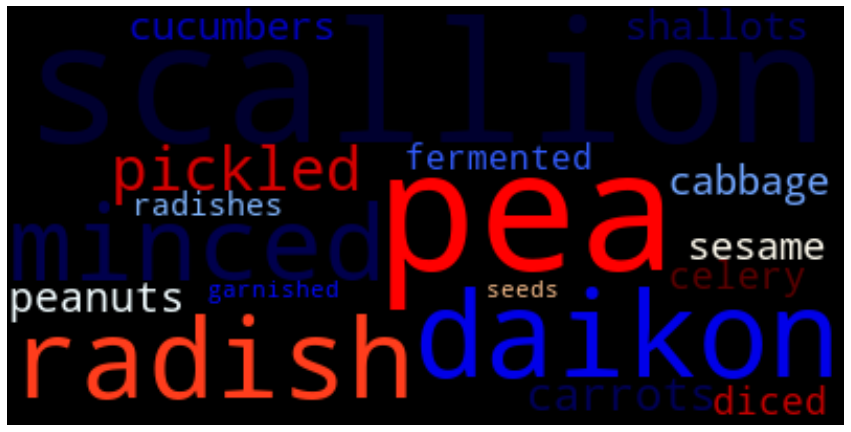

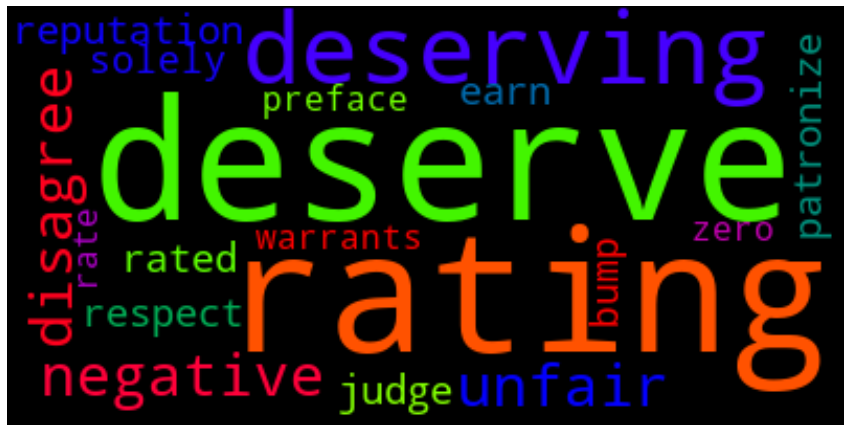

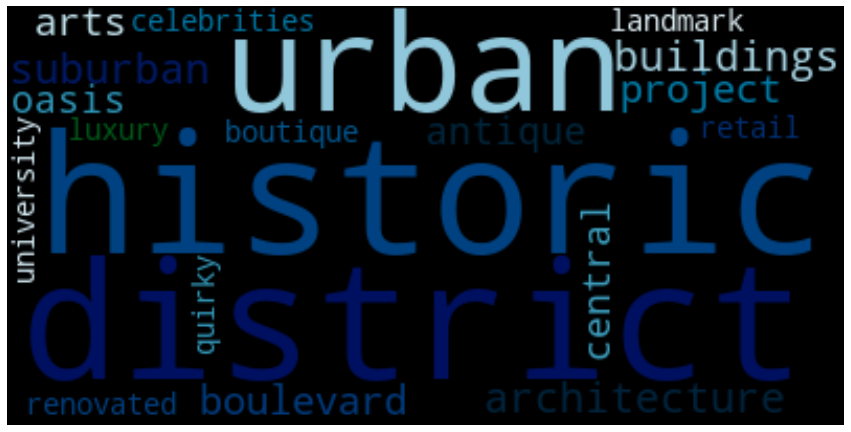

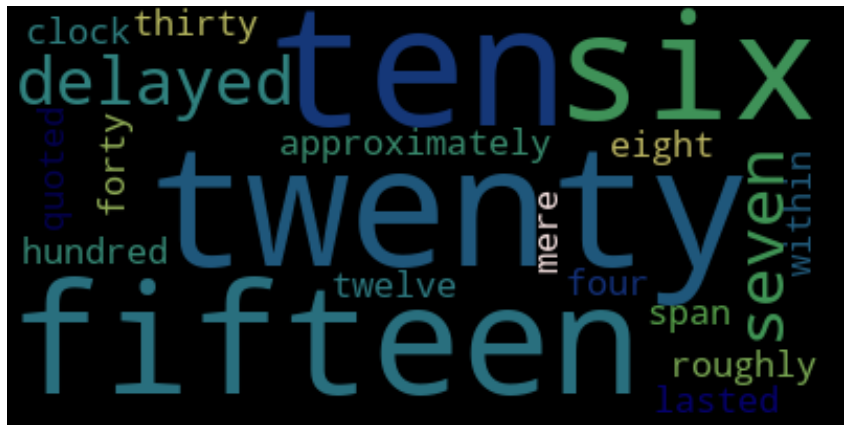

In [66]:
def display_cloud(cluster_index, color_map):
    print("Word clouds for each cluster: ")
    if len(top_words['Cluster #' + str(cluster_index)])>0:
        wc = WordCloud(background_color="black", max_words=2000, max_font_size=80, colormap=color_map)
        wordcloud = wc.generate(' '.join([word for word in top_words['Cluster #' + str(cluster_index)]]))
        plt.subplots(1,1, figsize=(15, 15))
        plt.plot()
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
#         plt.savefig('clusters/cluster_' + str(self.wve_model.most_similar(positive=[self.cluster_centers[cluster_index]], topn=1)[0][0]), bbox_inches='tight')



cmaps = cycle([
            'flag', 'prism', 'ocean', 'gist_earth', 'terrain', 'gist_stern',
            'gnuplot', 'gnuplot2', 'CMRmap', 'cubehelix', 'brg', 'hsv',
            'gist_rainbow', 'rainbow', 'jet', 'nipy_spectral', 'gist_ncar'])
for i in range(4):
    col = next(cmaps);
    display_cloud(i, col)

plt.show()

In [67]:
print("Saving cluster centroids...")
output = {}
output['embedding_size'] = 256
output['num_clusters'] = 120
output['cluster_centers'] = cluster_centers.tolist()

with open('./cluster_data.json', 'w') as of_handle:
    json.dump(output, of_handle)
    of_handle.close()

Saving cluster centroids...


In the next section, we process our review text into a form where for each review, we convert the review into its weighted centroid embedding form that was described earlier. This section of the code takes a **considerable time to run**.

In [68]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

class ClusterModelInput:
    def __init__(self):
        self.wve_model = gensim.models.Word2Vec.load('./wve.model')
        self.cluster_data_file_name = './cluster_data.json'
        self.dataset_location = './normalised_data.json'
        self.cluster_data = None
        self.useful_data = None
        self.tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
        self._stop_words_ = nltk.corpus.stopwords.words()
        self.clustering = joblib.load('./cluster.model')
        self.train_test_data_file_path = './train_test_data.json'

    def load_data(self):
        with open(self.cluster_data_file_name) as fh:
            self.cluster_data = json.load(fh)
            fh.close()

        with open(self.dataset_location, 'r') as fh:
            full_data = json.load(fh)
            self.useful_data = pd.DataFrame(json.loads(full_data[data_type]))
            fh.close()

    def prepare_input(self):
        df = self.useful_data.sample(frac=1).reset_index(drop=True)
        text_input = df['text'].tolist()
        transformed_text = []
        cluster_count = []

        for _, review in enumerate(text_input):
            no_tabs = str(review).replace('\t', ' ').replace('\n', '')
            alphas_only = re.sub("[^a-zA-Z\.]", " ", no_tabs)
            multi_spaces = re.sub(" +", " ", alphas_only)
            no_spaces = multi_spaces.strip()
            clean_text = no_spaces.lower()
            sentences = self.tokenizer.tokenize(clean_text)
            sentences = [re.sub("[\.]", "", sentence) for sentence in sentences]
            review_weights = range(self.cluster_data['num_clusters'])
            review_weights = dict(Counter(review_weights))
            review_weights = dict.fromkeys(review_weights, 0)

            if len(clean_text) > 0 and clean_text.count(' ') > 0:
                for sentence in sentences:
                    sentence = sentence.split(' ')
                    pruned_sentence = [self.get_cluster_bucket(word) for word in sentence if word not in self._stop_words_]

                    if len(pruned_sentence) > 0:
                        pruned_sentence = dict(Counter(pruned_sentence))
                        for key in review_weights:
                            if key in pruned_sentence:
                                review_weights[key] = review_weights[key] + pruned_sentence[key]
            
            sorted_review_weights = np.array([review_weights[key] for key in sorted(review_weights.keys())])
            final_weights = self.cluster_data['cluster_centers'] * sorted_review_weights[:, None]
            transformed_text.append(final_weights)
            cluster_count.append(sorted_review_weights)
        
        self.input_data = np.array(transformed_text)
        self.rf_input_data = np.array(cluster_count)
        self.labels = np.array(df[data_type].tolist())
        self.alternate_labels = np.array(df[data_type + '_raw'].tolist())

    def get_cluster_bucket(self, word):
        if word in self.wve_model.wv.vocab:
            word_embedding = self.wve_model.wv[word]
            return self.clustering.predict([word_embedding])[0]
        else:
            return -1

    def save_training_data(self):
        rows, _ = self.useful_data.shape
        split_point = int(math.floor(rows * 0.7))
        train_input = self.input_data[0:split_point, :]
        test_input = self.input_data[split_point:rows, :]
        rf_train_input = self.rf_input_data[0:split_point, :]
        rf_test_input = self.rf_input_data[split_point: rows, :]
        train_labels = self.labels[0:split_point]
        test_labels = self.labels[split_point:rows]
        train_alternate_labels = self.alternate_labels[0:split_point]
        test_alternate_labels = self.alternate_labels[split_point:rows]
        
        class_labels_train = []
        for l in train_labels:
            if l < 0.33:
                class_labels_train.append('low')
            elif l >= 0.33 and l < 0.66:
                class_labels_train.append('medium')
            elif l >= 0.66 and l <= 1.0:
                class_labels_train.append('high')
        
        encoder_train = LabelEncoder()
        encoder_train.fit(class_labels_train)
        encoded_labels_train = encoder_train.transform(class_labels_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        one_hot_labels_train = np_utils.to_categorical(encoded_labels_train)
        
        class_labels_test = []
        for l in test_labels:
            if l < 0.33:
                class_labels_test.append('low')
            elif l >= 0.33 and l < 0.66:
                class_labels_test.append('medium')
            elif l >= 0.66 and l <= 1.0:
                class_labels_test.append('high')

        encoder_test = LabelEncoder()
        encoder_test.fit(class_labels_test)
        encoded_labels_test = encoder_test.transform(class_labels_test)
        # convert integers to dummy variables (i.e. one hot encoded)
        one_hot_labels_test = np_utils.to_categorical(encoded_labels_test)
        
        oh_class_labels_train = []
        for l in train_labels:
            if l < 0.5:
                oh_class_labels_train.append('not ' + data_type)
            elif l >= 0.5:
                oh_class_labels_train.append(data_type)
        
        oh_encoder_train = LabelEncoder()
        oh_encoder_train.fit(oh_class_labels_train)
        oh_encoded_labels_train = oh_encoder_train.transform(oh_class_labels_train)
        # convert integers to dummy variables (i.e. one hot encoded)
        oh_one_hot_labels_train = np_utils.to_categorical(oh_encoded_labels_train)
        
        oh_class_labels_test = []
        for l in test_labels:
            if l < 0.5:
                oh_class_labels_test.append('not ' + data_type)
            elif l >= 0.5:
                oh_class_labels_test.append(data_type)

        oh_encoder_test = LabelEncoder()
        oh_encoder_test.fit(oh_class_labels_test)
        oh_encoded_labels_test = oh_encoder_test.transform(oh_class_labels_test)
        # convert integers to dummy variables (i.e. one hot encoded)
        oh_one_hot_labels_test = np_utils.to_categorical(oh_encoded_labels_test)
        
        return (train_input, test_input, train_labels, test_labels, one_hot_labels_train, one_hot_labels_test, rf_train_input, rf_test_input, oh_one_hot_labels_train, oh_one_hot_labels_test)

model = ClusterModelInput()
model.load_data()
model.prepare_input()
train_input, test_input, train_labels, test_labels, train_alternate_labels, test_alternate_labels, rf_train_input, rf_test_input, oh_train_labels, oh_test_labels = model.save_training_data()

Now that we have our input data and labels in the correct format, we will train a dense neural network model to classify the data into one of three categories, wherein the values of 0 to 0.33 for 'useful', 'funny' and 'cool' fall into a class called 'low', the values for 0.33 to 0.66 fall into another class called 'medium' and finally the values for 0.66 to 1.0 fall into a class called 'high'. We thus hope to classify a given review as being low, medium or high in terms of 'usefulness', 'funniness' or 'coolness'.

In [69]:
import tensorflow as tf
import json
import tensorflow.keras.backend as K
from keras.activations import softmax
import numpy as np

class ClusterModel:
    def __init__(self, train_data, test_data, train_labels, test_labels):
        self.model = None
        self.embedding_size = None
        self.num_clusters = None
        self.cluster_data_file_name = './cluster_data.json'
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.read_data()
        self.create_model()
        self.train_model()
        self.predict_and_evaluate()

    def create_model(self):
        print('Building model...')
        model = tf.keras.Sequential()
        dense_layer = tf.keras.layers.Dense(500, activation='relu', kernel_initializer='glorot_uniform', input_shape=(self.num_clusters, self.embedding_size))
        model.add(dense_layer)
        dense_layer_2 = tf.keras.layers.Dense(300, activation='relu')
        model.add(dense_layer_2)
        flatten_layer = tf.keras.layers.Flatten()
        model.add(flatten_layer)
        dense_layer_3 = tf.keras.layers.Dense(3, activation='softmax')
        model.add(dense_layer_3)

        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse', 'mae'])
        self.model = model
        print(model.summary())

    def read_data(self):
        print('Reading data...')
        with open(self.cluster_data_file_name) as fh:
            data = json.load(fh)
            self.embedding_size = data['embedding_size']
            self.num_clusters = data['num_clusters']
            fh.close()
    
    def train_model(self):
        print('Training model...')
        self.model.fit(self.train_data, self.train_labels, batch_size = 128, epochs = 5, validation_split = 0.3)

    def predict_and_evaluate(self):
        print('Predicting...')
        target_names = ['class 0', 'class 1', 'class 2']
        pred = self.model.predict(self.test_data)
        pred_labels = []
        true_labels = []
        
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_labels:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels, target_names=target_names))
        
        
cluster_model = ClusterModel(train_input, test_input, train_alternate_labels, test_alternate_labels)

Reading data...
Building model...
Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 120, 500)          128500    
_________________________________________________________________
dense_35 (Dense)             (None, 120, 300)          150300    
_________________________________________________________________
flatten_6 (Flatten)          (None, 36000)             0         
_________________________________________________________________
dense_36 (Dense)             (None, 3)                 108003    
Total params: 386,803
Trainable params: 386,803
Non-trainable params: 0
_________________________________________________________________
None
Training model...
Train on 6468 samples, validate on 2772 samples
Epoch 1/5
6468/6468 [==============================] - 16s 2ms/sample - loss: 1.1762 - mean_squared_error: 0.2266 - mean_absolute_error: 0.4

/Users/lindawong/Documents/Github/yelp_review_prediction/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Model with random forests:
As we can see above, we get a marginal improvement in accuracy. Next, we will try using a random forest to classify this data. Random forest is an ensemble method that consists of multiple decision trees. For this classifier, the input data is only the weights that are assigned to each of the cluster centers. For example, if we decide that the words 'cook', 'bake' and 'fry' would help determine whether a review is useful or not, then for each review, we would look at each word within the review and determine which of the above three words it is closest to in terms of its word vector embedding. Let us say that a review contains three words that are closest to 'cook', four closest to 'bake' and one closest to 'fry'. The input to the network is then the array [3, 4, 1]. Again, we try to classify each review into one of three categories.

In [70]:
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier


class RandomForest:
    def __init__(self):
        self.cluster_data_file_name = './cluster_data.json'
        self.rf_train_data = rf_train_input
        self.train_labels = train_alternate_labels
        self.rf_test_data = rf_test_input
        self.test_labels = test_alternate_labels
        
        self.train_model()
        self.predict_and_evaluate()

    def train_model(self):
        print('Training model...')
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=0)
        self.classifier.fit(self.rf_train_data, self.train_labels)
    
    def predict_and_evaluate(self):
        print('Predicting...')
        target_names = ['class 0', 'class 1', 'class 2']
        pred = self.classifier.predict(self.rf_test_data)
        pred_labels = []
        true_labels = []
        
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_labels:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels, target_names=target_names))
        

model = RandomForest()

Training model...
Predicting...
              precision    recall  f1-score   support

     class 0       0.37      0.95      0.53      1417
     class 1       0.63      0.17      0.27      1170
     class 2       0.40      0.01      0.03      1373

    accuracy                           0.39      3960
   macro avg       0.47      0.38      0.28      3960
weighted avg       0.46      0.39      0.28      3960



As we can see, this model does not perform much better than the previous model. Therefore, we will rephrase our classification task as a binary classification task wherein we determine if a review is 'useful', 'funny' and 'cool' or it is 'not useful', 'not funny' and 'not cool'. Therefore, any values for the 'useful', 'funny' and 'cool' columns that fall below 0.5 are treated as not useful and any values in the range of 0.5 to 1 are treated as useful.

In [71]:
import json
import numpy as np
from sklearn.ensemble import RandomForestClassifier


class RandomForest:
    def __init__(self):
        self.cluster_data_file_name = './cluster_data.json'
        self.rf_train_data = rf_train_input
        self.train_labels = oh_train_labels
        self.rf_test_data = rf_test_input
        self.test_labels = oh_test_labels
        
        self.train_model()
        self.predict_and_evaluate()

    def train_model(self):
        print('Training model...')
        self.classifier = RandomForestClassifier(n_estimators=100, random_state=0)
        self.classifier.fit(self.rf_train_data, self.train_labels)
    
    def predict_and_evaluate(self):
        print('Predicting...')
        target_names = ['class 0', 'class 1']
        pred = self.classifier.predict(self.rf_test_data)
        pred_labels = []
        true_labels = []
        
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_labels:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels, target_names=target_names))

model = RandomForest()

Training model...
Predicting...
              precision    recall  f1-score   support

     class 0       0.57      0.63      0.60      2007
     class 1       0.57      0.52      0.55      1953

    accuracy                           0.57      3960
   macro avg       0.57      0.57      0.57      3960
weighted avg       0.57      0.57      0.57      3960



We see that the accuracy increases significantly which is expected because we reduced the dimensionality of the output classifications. We can try the same classification task with the dense neural network model to see whether it improves the accuracy of the binary classification task. However, we do not expect to see a significant improvement using this network.

In [72]:
import tensorflow as tf
import json
import tensorflow.keras.backend as K
from keras.activations import softmax
import numpy as np

class ClusterModel:
    def __init__(self, train_data, test_data, train_labels, test_labels):
        self.model = None
        self.embedding_size = None
        self.num_clusters = None
        self.cluster_data_file_name = './cluster_data.json'
        self.train_data = train_data
        self.test_data = test_data
        self.train_labels = train_labels
        self.test_labels = test_labels
        self.read_data()
        self.create_model()
        self.train_model()
        self.predict_and_evaluate()

    def create_model(self):
        print('Building Model...')
        model = tf.keras.Sequential()

        dense_layer = tf.keras.layers.Dense(500, activation='relu', kernel_initializer='glorot_uniform', input_shape=(self.num_clusters, self.embedding_size))
        model.add(dense_layer)
        dense_layer_2 = tf.keras.layers.Dense(300, activation='relu')
        model.add(dense_layer_2)
        flatten_layer = tf.keras.layers.Flatten()
        model.add(flatten_layer)
        dense_layer_3 = tf.keras.layers.Dense(2, activation='softmax')
        model.add(dense_layer_3)

        model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = 0.01), metrics = ['mse', 'mae'])
        self.model = model
        print(model.summary())

    def read_data(self):
        print('Reading data...')
        with open(self.cluster_data_file_name) as fh:
            data = json.load(fh)
            self.embedding_size = data['embedding_size']
            self.num_clusters = data['num_clusters']
            fh.close()
    
    def train_model(self):
        print('Training model...')
        self.model.fit(self.train_data, self.train_labels, batch_size = 128, epochs = 5, validation_split = 0.3)

    def predict_and_evaluate(self):
        print('Predicting...')
        target_names = ['class 0', 'class 1']
        pred = self.model.predict(self.test_data)
        pred_labels = []
        true_labels = []
        
        for value in pred:
            pred_labels.append(np.argmax(value))
        
        for value in self.test_labels:
            true_labels.append(np.argmax(value))
        
        print(classification_report(true_labels, pred_labels, target_names=target_names))
cluster_model = ClusterModel(train_input, test_input, oh_train_labels, oh_test_labels)

Reading data...
Building Model...
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 120, 500)          128500    
_________________________________________________________________
dense_38 (Dense)             (None, 120, 300)          150300    
_________________________________________________________________
flatten_7 (Flatten)          (None, 36000)             0         
_________________________________________________________________
dense_39 (Dense)             (None, 2)                 72002     
Total params: 350,802
Trainable params: 350,802
Non-trainable params: 0
_________________________________________________________________
None
Training model...
Train on 6468 samples, validate on 2772 samples
Epoch 1/5
6468/6468 [==============================] - 9s 1ms/sample - loss: 0.8251 - mean_squared_error: 0.2566 - mean_absolute_error: 0.49

/Users/lindawong/Documents/Github/yelp_review_prediction/venv/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


As expected, this model provides a similar accuracy to the previous one.

## Conclusion:

In this project, we set out to create a model which can help Yelp in determining how useful, funny or cool a new review is. To start off, we tried to frame this as a regression task wherein we determine the usefulness, funniness or coolness of a review on a scale of 0 to 1, 0 being not useful and 1 being very useful. However, we soon learned that this was not feasible and we had to reframe our problem as a classification task. On running various models to classify each review, we have come to the conclusion that due to some inherent bias's present in the review data, it is difficult to model a good estimator for how useful, funny or cool a given review is. This happens due to various factors, some of which are explained below:

* Two reviews that are equalliy similar in terms of content and length have vastly different counts for 'useful' and 'funny' within the training data. This might be due to the fact that some restaurants are located in more populated areas and as a result have a larger number of upvotes on their reviews.
* Some reviews which are quite useful, funny, or cool simply do not have many upvotes. This could be due to the fact that they were not online for a large amount of time before the data was harvested or simply because the restaurants did not get many visitors and thus do not get many upvotes on Yelp.
* Usefulness, funniness and coolness are subjective criteria by which one measures the quality of a review. What one person or demographic finds as useful might not be useful at all in another demographic. From personal experiences of using Yelp in London, it was quite important to see the proximity of a certain restaurant to a local train station or underground station in London. We would consider a review that mentions such details as more useful than one that does not simply because public transport is the most widely used form of transport in London. However, when reading through reviews in LA for example, the proximity of the restaurant to public transport is not important at all. Due to the precense of such bias's in the data, we surmise that there is no clear underlying pattern in the data that can help us in modeling a good estimator of 'usefulness', 'funniness' or 'coolness' of a review.